In [36]:
%load_ext autoreload
%autoreload 2

import torch
from diffusers import ControlNetModel
from diffusers import DPMSolverMultistepScheduler

from text3d2video.attn_processor import MyAttnProcessor
from text3d2video.ipython_utils import display_ims
from text3d2video.pipelines.controlnet_pipeline import ControlNetPipeline
from text3d2video.rendering import render_depth_map

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
sd_repo = "runwayml/stable-diffusion-v1-5"
dtype = torch.float16
device = torch.device("cuda")

controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

controlnet = ControlNetModel.from_pretrained(controlnet_repo, torch_dtype=dtype).to(
    device
)

pipe = ControlNetPipeline.from_pretrained(
    sd_repo, controlnet=controlnet, torch_dtype=dtype
).to(device)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

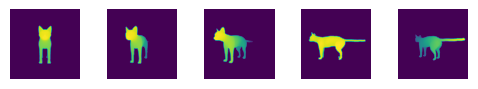

In [38]:
from pytorch3d.io import load_objs_as_meshes, load_obj

from text3d2video.camera_placement import turntable_cameras

mesh_path = "data/meshes/cat.obj"

# read animation
device = torch.device("cuda")
mesh = load_objs_as_meshes([mesh_path], device=device)

_, faces, aux = load_obj(mesh_path)
verts_uvs = aux.verts_uvs
faces_uvs = faces.textures_idx

dist = 2
cameras = turntable_cameras(dist, 100, device)
meshes = mesh.extend(len(cameras))

indices = [0, 5, 10, 25, 35]
cameras = cameras[indices]
meshes = meshes[indices]
n_images = len(cameras)

depth_maps = render_depth_map(meshes, cameras)
display_ims(depth_maps)

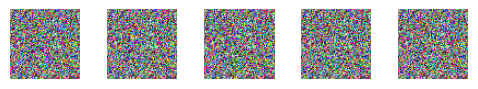

In [39]:
from text3d2video.uv_noise import prepare_uv_initialized_latents
import torchvision.transforms.functional as TF

gen = torch.Generator(device=device)
gen.manual_seed(0)

latents = prepare_uv_initialized_latents(
    meshes, cameras, verts_uvs, faces_uvs, latent_texture_res=70
)

latents_ims = latents[:, 0:3, :, :].cpu()
latents_ims = [TF.to_pil_image(latent) for latent in latents_ims]
display_ims(latents_ims, scale=1)

In [40]:
from typing import List
import matplotlib.pyplot as plt


def display_outputs(images: List, target_frame_indices: List, do_st_attn: bool = False):
    scale = 7
    fig, axs = plt.subplots(1, len(images), figsize=(scale * len(images), scale))

    for i, im in enumerate(images):
        axs[i].imshow(im)

        if i in target_frame_indices and do_st_attn:
            for spine in axs[i].spines.values():
                spine.set_edgecolor("red")
                spine.set_linewidth(5)

        else:
            axs[i].axis("off")

        axs[i].set_xticks([])
        axs[i].set_yticks([])

    plt.tight_layout()
    pass

100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


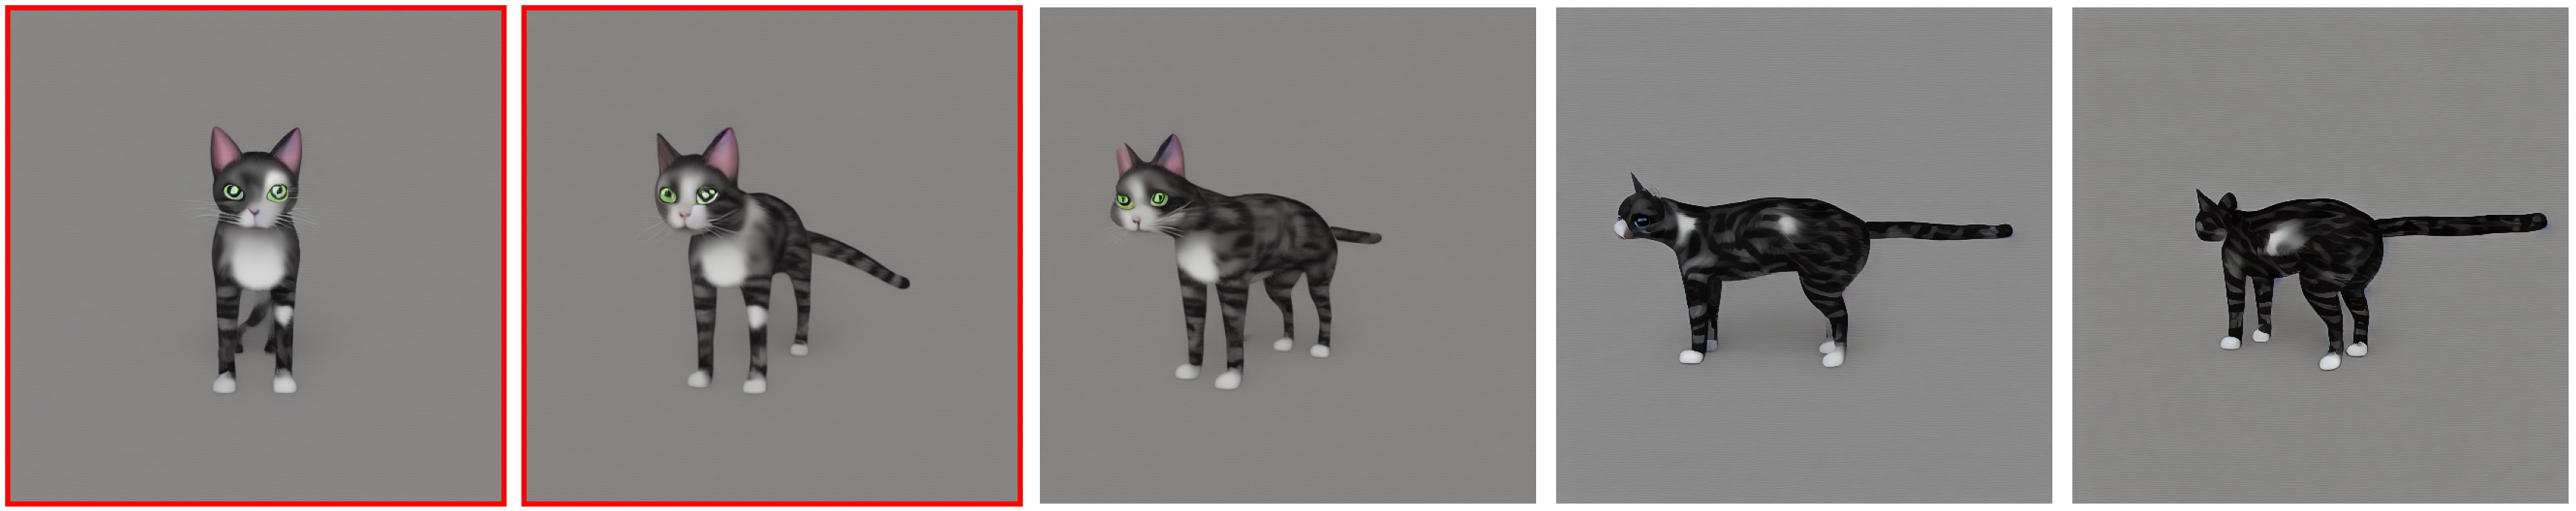

In [41]:
from pathlib import Path
import shutil
from text3d2video.attn_processor import SaveConfig
from text3d2video.disk_multidict import TensorDiskMultiDict
from text3d2video.util import ordered_sample

prompt = "Cat"

folder = Path("outs/tensors")
if folder.exists():
    shutil.rmtree(folder)
folder.mkdir(parents=True)

saved_tensors = TensorDiskMultiDict(folder)


def pre_step(t, i):
    attn_processor.cur_timestep = t
    attn_processor.cur_timestep_idx = i


pipe.pre_step_callback = pre_step

n_inference_steps = 10

save_cfg = SaveConfig()
save_cfg.save_steps = ordered_sample(range(n_inference_steps), 2)

do_st_attn = True
target_frame_indices = [0, 1]

attn_processor = MyAttnProcessor(pipe.unet)
attn_processor.save_cfg = save_cfg
attn_processor.target_frame_indices = target_frame_indices
attn_processor.do_st_extended_attention = do_st_attn
attn_processor.saved_tensors = saved_tensors
pipe.unet.set_attn_processor(attn_processor)

gen = torch.Generator(device=device)
gen.manual_seed(0)

prompts = [prompt] * n_images

images = pipe(
    prompts,
    depth_maps,
    generator=gen,
    initial_latents=latents,
    num_inference_steps=n_inference_steps,
)
display_outputs(images, target_frame_indices, do_st_attn)

In [33]:
from text3d2video.sd_feature_extraction import get_module_from_path

saved_tensors = attn_processor.saved_tensors

layers = list(saved_tensors.key_values("layer"))
layers = sorted(layers)
timesteps = list(saved_tensors.key_values("timestep"))
timesteps = sorted(timesteps)

print(timesteps)
for layer in layers:
    print(layer)

['0', '9']
down_blocks.0.attentions.0.transformer_blocks.0.attn1
down_blocks.0.attentions.1.transformer_blocks.0.attn1
down_blocks.1.attentions.0.transformer_blocks.0.attn1
down_blocks.1.attentions.1.transformer_blocks.0.attn1
down_blocks.2.attentions.0.transformer_blocks.0.attn1
down_blocks.2.attentions.1.transformer_blocks.0.attn1
mid_block.attentions.0.transformer_blocks.0.attn1
up_blocks.1.attentions.0.transformer_blocks.0.attn1
up_blocks.1.attentions.1.transformer_blocks.0.attn1
up_blocks.1.attentions.2.transformer_blocks.0.attn1
up_blocks.2.attentions.0.transformer_blocks.0.attn1
up_blocks.2.attentions.1.transformer_blocks.0.attn1
up_blocks.2.attentions.2.transformer_blocks.0.attn1
up_blocks.3.attentions.0.transformer_blocks.0.attn1
up_blocks.3.attentions.1.transformer_blocks.0.attn1
up_blocks.3.attentions.2.transformer_blocks.0.attn1


{'layer': 'up_blocks.3.attentions.1.transformer_blocks.0.attn1', 'timestep': '0'}


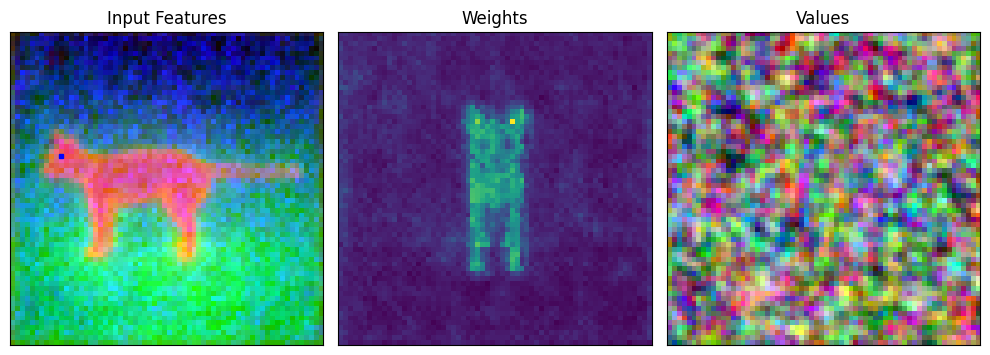

In [35]:
from torch import Tensor
from text3d2video.visualization import visualize_attention_weights

timestep = timesteps[0]
layer = layers[14]

identifier = {
    "layer": layer,
    "timestep": timestep,
}

print(identifier)

frame_idx = 3

attn = get_module_from_path(pipe.unet, layer)

# get key, query, value for frame
x = saved_tensors[identifier | {"name": "x"}][frame_idx]
qrys = saved_tensors[identifier | {"name": "query"}][frame_idx]
keys = saved_tensors[identifier | {"name": "key"}][frame_idx]
vals = saved_tensors[identifier | {"name": "value"}][frame_idx]

head_idx = 3
pixel_coord = Tensor([10, 25]).int()

visualize_attention_weights(
    x,
    qrys,
    keys,
    vals,
    attn,
    pixel_coord,
    head_idx,
    normalize_weights=True,
    temperature=3,
)